In [85]:
import gurobipy as gp
import itertools as it
import networkx as nx
import pandas as pd
import numpy as np
import math
import re

import seaborn as sns
import matplotlib.pyplot as plt


"""
implementation of solving profit maximization problem
author: 
yk796@cornell.edu
"""

'\nimplementation of solving profit maximization problem\nauthor: \nyk796@cornell.edu\n'

In [86]:
data_type = "SiouxFalls" #"Test_0" # "Anaheim" # 
alpha = 0.15
beta = 4.0
m_list = ["m1"]


# link to https://github.com/bstabler/TransportationNetworks/tree/master/SiouxFalls

network_df = pd.read_csv("../data/{}/{}_net.txt".format(data_type, data_type), sep='\t', comment=';')
# node_df = pd.read_csv("../data/{}/{}_node.txt".format(data_type, data_type), sep='\t', comment=';')
od_df = pd.read_csv("../data/{}/{}_od.csv".format(data_type, data_type))
    
R = pd.read_pickle("../data/{}/OD_route.pickle".format(data_type))

demand = {(int(row['O']), int(row['D'])): row['Ton'] for index, row in od_df.iterrows()}
ods = list(demand.keys() )


# network_df = network_df[['init_node', 'term_node', 'capacity', 'length', 'free_flow_time', 'b',
#        'power', 'speed', 'toll', 'link_type']]
network_df = network_df[['init_node', 'term_node', 'capacity', 'free_flow_time', 'b',
       'power', 'speed', 'toll', 'link_type']] #chicago
network_df['length'] = network_df['free_flow_time'] * network_df['speed']

network_df[['init_node', 'term_node']] = network_df[['init_node', 'term_node']].astype(int)
# node_df = node_df[['Node', 'X', 'Y']]

road_link = [(int(row['init_node']), int(row['term_node']), row['length']) for _, row in network_df.iterrows()]

arcs = list(network_df[['init_node', 'term_node']].to_records(index=False))

bpr_func = {}
link_capacity = {}
free_flow_time_dict = {}

for index, row in network_df.iterrows():
    init_node, term_node = int(row['init_node']), int(row['term_node'])
    free_flow_time, b, capacity, power = row['free_flow_time'], row['b'], row['capacity'], row['power']
    free_flow_time_dict[((init_node, term_node))] = free_flow_time
    bpr_func[(init_node, term_node)] = lambda flow, f=free_flow_time, c=capacity, p=power: f * (1 + alpha * (flow / c)) # 1 should be substitue with power
    link_capacity[(init_node, term_node)] = capacity


# print("Number of nodes:", len(node_df))
print("Number of links:", len(network_df))
print("Number of od pairs:", len(od_df))

total_demand = od_df['Ton'].sum()
C = 1

Number of links: 76
Number of od pairs: 528


In [87]:
od_matrix_pivot = od_df.pivot(index='O', columns='D', values='Ton').fillna(0)
vmax_value = od_matrix_pivot.max().max()

In [88]:
# positive_values = od_matrix_pivot[od_matrix_pivot > 0].stack()
positive_values = od_matrix_pivot.stack()
variance_of_positive_values = positive_values.var()
variance_of_positive_values

480538.0434782623

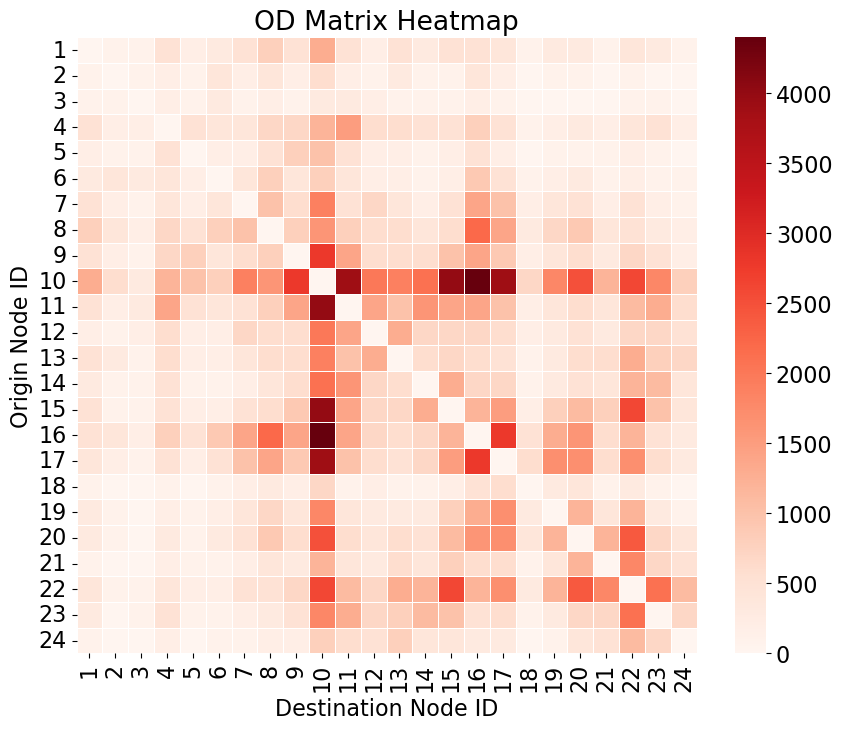

In [89]:
def plot_od_heatmap(df, value_column, title, cmap='Reds', save_path=None, figsize=(10, 8), annot=False):
    """
    This function plots and saves a heatmap for an OD matrix.

    Parameters:
    - df: DataFrame containing the OD data.
    - value_column: The name of the column in df that contains the values to plot.
    - title: Title for the heatmap.
    - cmap: Colormap to be used for heatmap.
    - save_path: Path to save the figure (including the filename).
    - figsize: Size of the figure.
    - annot: If True, the values will be shown on the heatmap.
    """
    # Pivot the table to get a matrix where index is 'O', columns are 'D', and cell values are the specified 'value_column'
    od_matrix_pivot = df.pivot(index='O', columns='D', values=value_column).fillna(0)
    vmax_value = od_matrix_pivot.max().max()

    # Plotting the heatmap
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(od_matrix_pivot, cmap=cmap, linewidths=.5, annot=annot, vmin=0, vmax=vmax_value)
    plt.title(title)
    plt.xlabel('Destination Node ID')
    plt.ylabel('Origin Node ID')

    # If a save path is provided, save the figure
    if save_path:
        plt.savefig(save_path)

    # Show the heatmap
    plt.show()

plot_od_heatmap(od_df, 'Ton', 'OD Matrix Heatmap', save_path='../figures/od_matrix_heatmap.pdf', annot=False)

# draw for each modes


In [90]:
import json

# Path to the JSON file


f_am_path = '../output/{}/f_am.json'.format(data_type)
p_ijmr_path = '../output/{}/p_ijmr.json'.format(data_type)


# Reading the JSON file
with open(f_am_path, 'r') as file:
    f_am = json.load(file)

with open(p_ijmr_path, 'r') as file:
    p_ijmr = json.load(file)


# # Print the entire JSON data
# print(json.dumps(data, indent=4))
f_am_dict = {"m1": {}}
# Assuming you know the keys and structure, for example:
for key, value in f_am.items():
    pattern = r"\(\((\d+), (\d+)\), (m\d+)\)"

    match = re.match(pattern, key)
    if match:
        a1, a2, m = int(match.group(1)), int(match.group(2)), match.group(3)
        f_am_dict[m][(a1, a2)] = value['value'] * C
    else:
        print("No match found.")


p_ijmr_dict = {"m1": {}}

# Assuming you know the keys and structure, for example:
for key, value in p_ijmr.items():
    pattern = r"\(\((\d+), (\d+)\), \"(m\d+)\", (\d+)\)"

    match = re.match(pattern, key)
    if match:
        a1, a2, m, r = int(match.group(1)), int(match.group(2)), match.group(3), int(match.group(4))
        p_ijmr_dict[m][(a1, a2), r] = value
    else:
        print("No match found.")


In [91]:
sum(p_ijmr.values())

1.0000000159906515

In [92]:
# level of service is normally measured by volumn to capacity ratio
congest_index = {}
for (a_ind, (i,j)) in enumerate(arcs):
    congest_index[(i,j)] = f_am["({}, m1)".format(arcs[a_ind])]['value']/link_capacity[(i,j)]
    

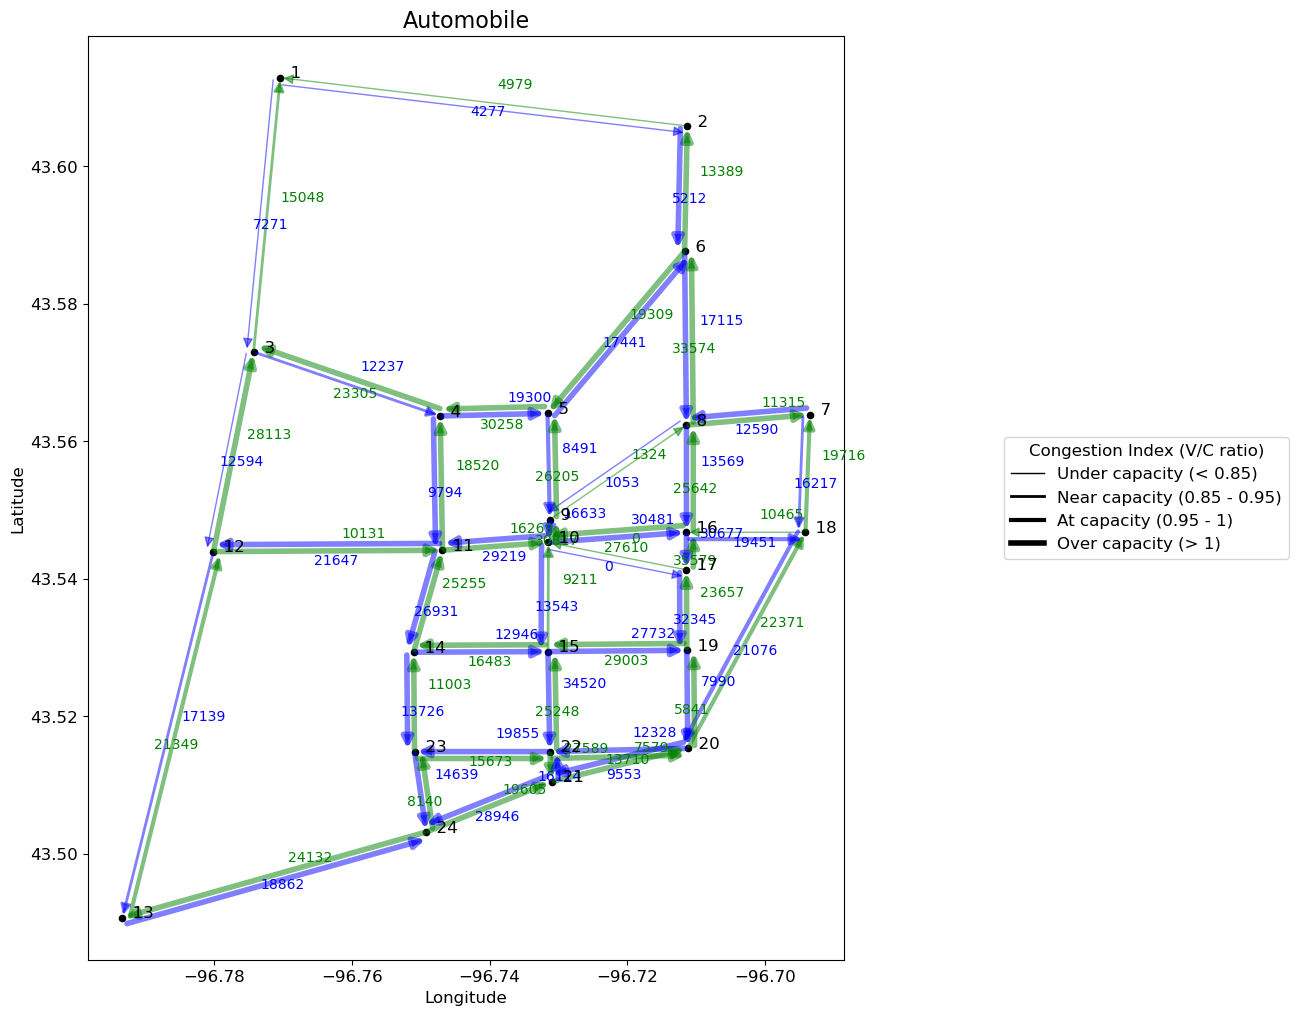

In [102]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import Point
import json
import numpy as np
from matplotlib.lines import Line2D

# Read the JSON file into a Python dictionary

with open('../data/{}/{}_geo.json'.format(data_type, data_type), 'r') as f:
    loaded_geojson_data = json.load(f)

# Convert the loaded GeoJSON to a Geopandas DataFrame
gdf = gpd.read_file(json.dumps(loaded_geojson_data))


# Function to determine line width based on congestion index
def get_line_width(congest_index_value):
    if congest_index_value < 0.6:
        return 1  # width for x < 0.6
    elif 0.6 <= congest_index_value <= 0.8:
        return 2  # width for 0.6 <= x <= 0.8
    elif 0.8 < congest_index_value < 1:
        return 3  # width for 0.8 < x < 1
    else:
        return 4  # width for x >= 1

def draw_plot(dict, m,  ax, title):
    data = dict[m]
    bidirectional_edges = {}  # To store pairs that are bi-directional
    
    # Plot the points
    # fig, ax = plt.subplots(figsize=(12, 7))
    gdf.plot(ax=ax, markersize=20, color='black', marker='o')

    # Helper function to offset points for drawing bi-directional edges and annotations
    def offset_points(x1, y1, x2, y2, offset=0.001):
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)
        dx /= length
        dy /= length
        return x1 + offset * dy, y1 - offset * dx, x2 + offset * dy, y2 - offset * dx



    for (a1, a2), flow in data.items():

        point1 = gdf[gdf['id'] == a1].iloc[0]
        point2 = gdf[gdf['id'] == a2].iloc[0]
        
        mid_x = (point1.geometry.x + point2.geometry.x) / 2
        mid_y = (point1.geometry.y + point2.geometry.y) / 2
        
        arrow_color = 'k'
        text_color = 'red'
        
        # Determine the color based on direction
        if a1 < a2:  # For demonstration, assuming low to high id is blue
            arrow_color = 'blue'
            text_color = 'blue'
        else:  # high to low id is green
            arrow_color = 'green'
            text_color = 'green'



        # Check if the link is bi-directional
        if (a2, a1) in bidirectional_edges:
            x1, y1, x2, y2 = offset_points(point1.geometry.x, point1.geometry.y, point2.geometry.x, point2.geometry.y)
            # arrow = FancyArrowPatch((x1, y1), (x2, y2), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=congest_index[tuple(arcs[link])])
            if data_type == "SiouxFalls" and m == "m1":
                arrow = FancyArrowPatch((x1, y1), (x2, y2), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=get_line_width(congest_index[(a1, a2)]), alpha=0.5) 
            else:
                arrow = FancyArrowPatch((x1, y1), (x2, y2), mutation_scale=15, arrowstyle='-|>', color=arrow_color) 

            ax.add_patch(arrow)
            ax.text(mid_x - 0.002, mid_y - 0.002, str(round(flow)), color=text_color, fontsize=10)
        else:
            if data_type == "SiouxFalls" and m == "m1":
                arrow = FancyArrowPatch((point1.geometry.x, point1.geometry.y), (point2.geometry.x, point2.geometry.y), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=get_line_width(congest_index[(a1, a2)]), alpha=0.5)
            else:
                arrow = FancyArrowPatch((point1.geometry.x, point1.geometry.y), (point2.geometry.x, point2.geometry.y), mutation_scale=15, arrowstyle='-|>', color=arrow_color)
            
            ax.add_patch(arrow)
            ax.text(mid_x + 0.002, mid_y + 0.002, str(round(flow)), color=text_color, fontsize=10)
            bidirectional_edges[(a1, a2)] = True  # Mark this link as seen

    # plot points
    for x, y, label in zip(gdf['geometry'].apply(lambda p: p.x), gdf['geometry'].apply(lambda p: p.y), gdf["id"]):
        ax.text(x, y, f"  {label}")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("{}".format(title), fontsize=16)

    if data_type == "SiouxFalls" and m == "m1":
        legend_lines = [Line2D([0], [0], color='black', lw=get_line_width(width)) for width in [0.5, 0.7, 0.9, 1.1]]
        legend_labels = ['Under capacity (< 0.85)', 'Near capacity (0.85 - 0.95)', 'At capacity (0.95 - 1)', 'Over capacity (> 1)']
        ax.legend(legend_lines, legend_labels, loc='center left', bbox_to_anchor=(1.2, +0.5), ncol = 1, title='Congestion Index (V/C ratio)')

    ax.set_aspect(1) #the ratio of x-unit to y-unit



plt.rcParams.update({'font.size': 12})  # Set global font size

fig = plt.figure(figsize=(10, 12))  # Create a figure
ax = plt.gca()  # Get the current axes
draw_plot(f_am_dict, m_list[0], ax, "Automobile")  # Call your custom plotting function

plt.savefig("../figures/flow_counts.pdf", bbox_inches='tight')


# Note: we follow the definition here:
# https://www.oregon.gov/odot/Planning/Documents/V-CRatio_DelayPlanningDesignDecisions_SignalizedIntersections.pdf
# Adjust the legend for the congestion levels
plt.show()


In [94]:
# get V_ijmr 

subway_speed_factor = 1
walk_speed_factor = 1
bus_speed_factor = 1

network_df = pd.read_csv("../data/{}/{}_net.txt".format(data_type, data_type), sep='\t', comment=';')
def bpr_func(m, a, flow):
    row = network_df[(network_df['init_node'] == a[0]) & (network_df['term_node'] == a[1])].iloc[0] # there must be one row
    t_0, alpha, capacity, beta = row['free_flow_time'], row['b'], row['capacity'], row['power']

    if m == "m1": # road
        return t_0 * (1 + alpha * (flow / capacity)**beta)

def is_continuous_subsequence(my_tuple, my_list):
    tuple_length = len(my_tuple)
    list_length = len(my_list)
    
    for i in range(0, list_length - tuple_length + 1):
        if tuple(my_list[i:i+tuple_length]) == my_tuple:
            return True
    return False

V_ijmr = {}
epsilon_ijmr = {}
for od in ods:
    for m in ["m1"]:
        for r in R[od, m].keys():
            V_ijmr[m, od, r] = sum(f_am_dict[m][a] for a in f_am_dict[m] if is_continuous_subsequence(a,R[od,m][r]))
                # sum(p_ijmr[od, m, r] for od in ods for r in keys(R[od, m]) if is_continuous_subsequence(a,R[od, m][r]))

In [103]:
V_ijmr

{('m1', (2, 1), 0): 4978.882307754152,
 ('m1', (3, 1), 0): 15048.341676547036,
 ('m1', (4, 1), 0): 38353.564346838124,
 ('m1', (5, 1), 0): 68611.46653333599,
 ('m1', (6, 1), 0): 18368.213459518363,
 ('m1', (7, 1), 0): 64532.76032407781,
 ('m1', (8, 1), 0): 51942.31178778564,
 ('m1', (9, 1), 0): 94816.00011100146,
 ('m1', (10, 1), 0): 125633.4049596202,
 ('m1', (10, 1), 1): 94027.65570769308,
 ('m1', (11, 1), 0): 56873.79155788144,
 ('m1', (11, 1), 1): 64808.4082080543,
 ('m1', (12, 1), 0): 43161.48257715476,
 ('m1', (13, 1), 0): 64510.58155370249,
 ('m1', (14, 1), 0): 82128.71679662463,
 ('m1', (14, 1), 1): 90063.3334467975,
 ('m1', (15, 1), 0): 98611.38515362258,
 ('m1', (15, 1), 1): 179697.90870785346,
 ('m1', (15, 1), 2): 106546.00180379544,
 ('m1', (15, 1), 3): 164552.43876261316,
 ('m1', (16, 1), 0): 77584.59904569475,
 ('m1', (17, 1), 0): 113163.54469088529,
 ('m1', (18, 1), 0): 84248.49674912635,
 ('m1', (19, 1), 0): 136820.86261605265,
 ('m1', (19, 1), 1): 127614.43745585365,
 